In [1]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import pickle
import json
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import numpy as np

In [7]:
import pandas as pd
trainData = pd.read_csv('CleanData.csv',sep=',')
testData = pd.read_csv('CleanDataTest.csv',sep=',')

In [71]:
fileOpen = open('stopwords.txt','r')
StopWords = []
for eachWord in fileOpen:
    StopWords.append(eachWord.strip())
fileOpen.close()

In [8]:
trainData.columns

Index(['id', 'tweet', 'isVulgar', 'emoScore', 'label'], dtype='object')

In [9]:
testData.columns

Index(['id', 'tweet', 'isVulgar', 'emoScore'], dtype='object')

In [92]:
#Analysing TFIDF vectors 
def top_tfidf_feats(row, features, top_n=50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=50):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=50):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=50):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.80)
    plt.savefig('tfidf_words_picked_class_wise.png')
    plt.show()

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,file_name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in iter_tools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     fig = plt.figure(figsize=(8,8))

#     plt.figure(figsize=(10,10))
    
    plt.savefig(file_name)

In [93]:
tfidfVectors = TfidfVectorizer(analyzer='word',ngram_range=(1,3),stop_words= StopWords,
                                            norm='l2',max_features=1500,lowercase=True,sublinear_tf=True)
X_vector = tfidfVectors.fit_transform(trainData['tweet'])

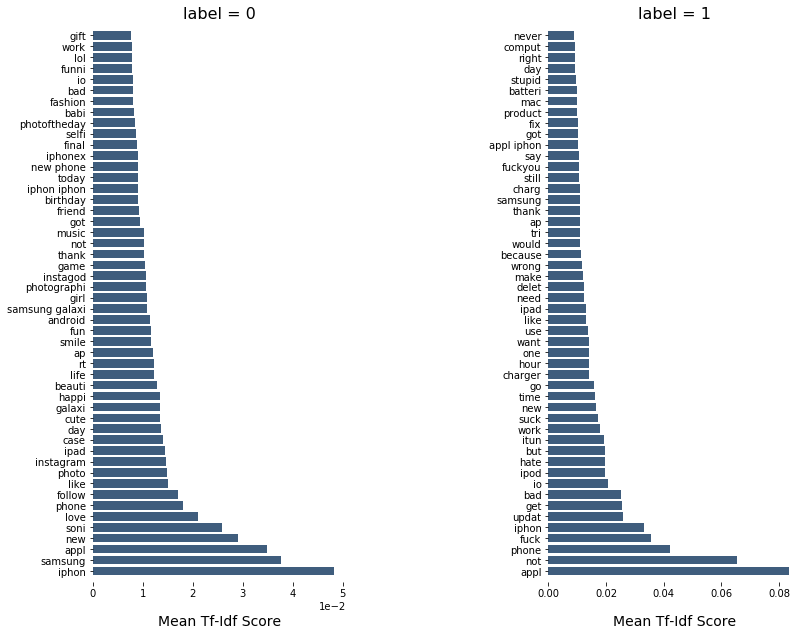

In [94]:
features = tfidfVectors.get_feature_names()
list_features = top_feats_by_class(X_vector,trainData['label'],features)
plot_tfidf_classfeats_h(list_features)


In [76]:
#Adding new features to TF-IDF vectors
XArray = X_vector.toarray()
X = XArray
len(X[0])


1500

In [77]:
additionalFeatures = trainData[['isVulgar', 'emoScore']].as_matrix()
X = np.concatenate((XArray,additionalFeatures),axis=1)


In [78]:
# additionalFeatures2 = trainData[['emoScore']].as_matrix()
# X = np.concatenate((XArray,additionalFeatures2),axis=1)


In [79]:
y = trainData['label']
labels_sorted = sorted(list(set(y)))

In [80]:
#Train Test Split
#For model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools as iter_tools

def get_train_test_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(
           X, y, test_size=0.2, random_state=42, stratify=y)
    return (X_train, X_test, y_train, y_test)

In [81]:
X_train, X_test, y_train, y_test = get_train_test_split(X,y)


In [82]:
# # naive bayes
# clf_nb = MultinomialNB()
# clf_nb.fit(X_train, y_train)

# pred_nb = clf_nb.predict(X_test)
# print(clf_nb.score(X_test, y_test))

# cnf_matrix_nb= confusion_matrix(y_true =y_test, y_pred  =pred_nb)
# np.set_printoptions(precision=2)


# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix_nb, classes=labels_sorted,file_name='naive_bayes',
#                       title='Confusion matrix, without normalization')
# plt.show()


0.8453282828282829
Confusion matrix, without normalization


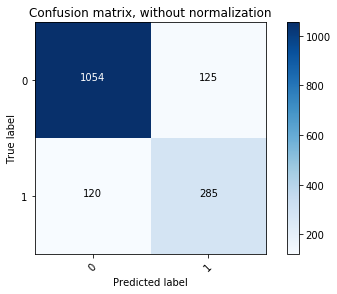

In [83]:
from sklearn.svm import SVC
# using svm

svm = SVC(C=1000000.0, gamma="auto", kernel='rbf')
svm.fit(X_train, y_train)
# perdict on test data 
pred_svm = svm.predict(X_test)
print(svm.score(X_test, y_test))
#print(confusion_matrix(pred_svm, y_test))

cnf_matrix_svm= confusion_matrix(y_true =y_test, y_pred  =pred_svm )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_svm, classes=labels_sorted,file_name='SVM',
                      title='Confusion matrix, without normalization')
plt.show()

In [84]:
svm.fit(X, y)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [85]:
X_test = tfidfVectors.transform(testData['tweet'])
XTestArray = X_test.toarray()
XTest = XTestArray
len(XTest[0])

additionalTestFeatures = testData[['isVulgar', 'emoScore']].as_matrix()
XTestFinal = np.concatenate((XTest,additionalTestFeatures),axis=1)

pred_svm = svm.predict(XTestFinal)

OutPut = pd.DataFrame( {'id': testData['id'],
                     'label':pred_svm})

OutPut.to_csv('submission2.csv',index=None)

In [57]:
OutPut.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,0


In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

Accuracy: 83.71%
Confusion matrix, without normalization


C:\HOMEWARE\Anaconda3-Windows-x86_64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


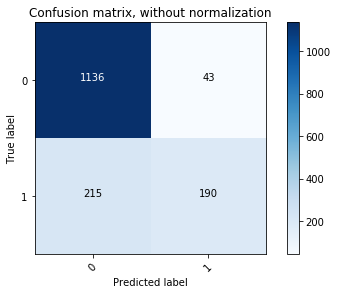

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# using xgboost

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
pred_xgboost = model.predict(X_test)
#predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, pred_xgboost)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

cnf_matrix_xgboost= confusion_matrix(y_true =y_test, y_pred  =pred_xgboost )
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_xgboost, classes=labels_sorted,file_name='xgboost',
                      title='Confusion matrix, without normalization')
plt.show()


In [66]:
def multi_class_acc(cnf_mat):
    
    tp = [0] * 5
    fp = [0] * 5
    tn = [0] * 5
    fn = [0] * 5
    acc = [0] * 5
    rows = cnf_mat.shape[0]
    cols = cnf_mat.shape[1]
    for counter in range(0,5):
        for x in range(0, rows):
            for y in range(0, cols):
                if(x==y):
                    tp[x]=cnf_mat[x][y]
                elif(counter == x):
                    fn[counter]=fn[counter]+cnf_mat[x][y]
                elif(counter == y):
                    fp[counter]=fp[counter]+cnf_mat[x][y]
                else:
                    tn[counter]=tn[counter]+cnf_mat[x][y]
        acc[counter]= (tp[counter]+tn[counter])/(tp[counter]+tn[counter]+fp[counter]+fn[counter])
    
    print('acc',acc)

In [67]:
multi_class_acc(cnf_matrix_xgboost)

acc [0.9642857142857143, 0.9787234042553191, 1.0, 0.9928825622775801, 0.8]


In [57]:
#For pickling model
file_Name = "xgb_classifier.p"
fileObject = open(file_Name,'wb') 
pickle.dump(model, fileObject)
fileObject.close()

#for Pickling TFIDF vectoriser
fileNameVectoriser = "tfidf_vectroizer_for_classification.p"
fileObjectVectoriser = open(fileNameVectoriser,'wb')
pickle.dump(tfidfVectors,fileObjectVectoriser)